# PyTorch MNIST Classifier

In this notebook I will implement a deep convolutional neural network to classify handwritten digits from the MNIST dataset.

Import all the necessary packages:

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

/home/uladzislau/miniconda3/envs/deep-learning-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device(
    'cuda' 
    if torch.cuda.is_available() 
    else 'cpu'
)
device

device(type='cuda')

Define image processing pipelines:

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #  transforms.RandomVerticalFlip(),
    transforms.ColorJitter(
        brightness=0,
        contrast=0,
        saturation=0,
        hue=0
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.1307,),
        std=(0.3081,)
    )
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.1307,),
        std=(0.3081)
    )
])

Download the dataset:

In [5]:
image_path = './'


mnist_data = torchvision.datasets.MNIST(
    root=image_path,
    train=True,
    download=False,
    transform=transform_train
)

Split training data and download test data:

In [6]:
mnist_valid_data = Subset(
    mnist_data,
    torch.arange(10_000)
)

mnist_train_data = Subset(
    mnist_data,
    torch.arange(
        10_000, len(mnist_data) 
    )
)

mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=False,
    download=False,
    transform=transform_test
)

Set up data loaders:

In [7]:
batch_size = 64
torch.manual_seed(1)

train_loader = DataLoader(
    mnist_train_data,
    batch_size,
    shuffle=True
)

valid_loader = DataLoader(
    mnist_valid_data,
    batch_size,
    shuffle=False
)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=32,
                kernel_size=5, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=32, out_channels=64,
                kernel_size=5, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(3136, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        return self.classifier(x)

In [9]:
mnist_net = Net().to(device)
mnist_net

Net(
  (classifier): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=1024, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1e-3)

In [11]:
def train(model, n_epochs, train_dl, valid_dl):
    loss_history_train = [0] * n_epochs
    loss_history_valid = [0] * n_epochs
    accuracy_history_train = [0] * n_epochs
    accuracy_history_valid = [0] * n_epochs

    for epoch in range(n_epochs):
        model.train()

        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            prediction = model(x_batch)
            loss_value = loss_fn(prediction, y_batch)
            loss_value.backward()
            optimizer.step()

            loss_history_train[epoch] += loss_value.item() * y_batch.size(0)

            is_correct = (
                torch.argmax(prediction, dim=1) == y_batch
            ).float().cpu()

            accuracy_history_train[epoch] += is_correct.sum()
        
        loss_history_train[epoch] /= len(train_dl.dataset)
        accuracy_history_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                prediction = model(x_batch)
                loss_value = loss_fn(prediction, y_batch)

                loss_history_valid[epoch] += loss_value.item() * y_batch.size(0)

                is_correct = (
                    torch.argmax(prediction, dim=1) == y_batch
                ).float().cpu()

                accuracy_history_valid[epoch] += is_correct.sum()
        loss_history_valid[epoch] /= len(valid_dl.dataset)
        accuracy_history_valid[epoch] /= len(valid_dl.dataset)

        print(
            f'Epoch {epoch + 1} '
            f'train accuracy: {accuracy_history_train[epoch]:.3f} '
            f'validation accuracy: {accuracy_history_valid[epoch]:.3f}'
        )

    return loss_history_train, loss_history_valid,\
           accuracy_history_train, accuracy_history_valid 

In [12]:
n_epochs = 20
hist = train(
    mnist_net, n_epochs, 
    train_loader, valid_loader
)

Epoch 1 train accuracy: 0.926 validation accuracy: 0.976
Epoch 2 train accuracy: 0.973 validation accuracy: 0.979
Epoch 3 train accuracy: 0.979 validation accuracy: 0.984
Epoch 4 train accuracy: 0.983 validation accuracy: 0.985
Epoch 5 train accuracy: 0.985 validation accuracy: 0.985
Epoch 6 train accuracy: 0.986 validation accuracy: 0.984
Epoch 7 train accuracy: 0.989 validation accuracy: 0.986
Epoch 8 train accuracy: 0.989 validation accuracy: 0.985
Epoch 9 train accuracy: 0.990 validation accuracy: 0.988
Epoch 10 train accuracy: 0.991 validation accuracy: 0.986
Epoch 11 train accuracy: 0.991 validation accuracy: 0.987
Epoch 12 train accuracy: 0.992 validation accuracy: 0.986
Epoch 13 train accuracy: 0.993 validation accuracy: 0.987
Epoch 14 train accuracy: 0.993 validation accuracy: 0.986
Epoch 15 train accuracy: 0.993 validation accuracy: 0.986
Epoch 16 train accuracy: 0.993 validation accuracy: 0.984
Epoch 17 train accuracy: 0.994 validation accuracy: 0.988
Epoch 18 train accuracy

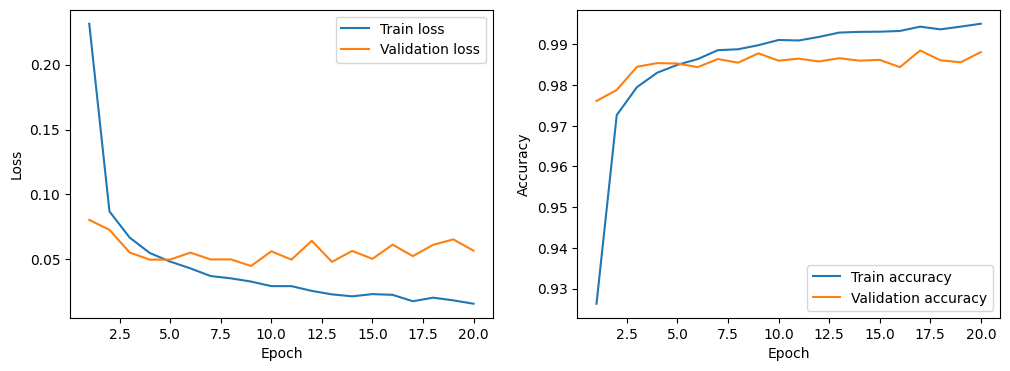

In [15]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], label='Train loss')
ax.plot(x_arr, hist[1], label='Validation loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], label='Train accuracy')
ax.plot(x_arr, hist[3], label='Validation accuracy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.show()